# Backpropagation Practice

Implement a 3 input, 4 node hidden-layer, 1 output node Multilayer Perceptron on the following dataset:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 0  | 0  | 1  | 0 |
| 0  | 1  | 1  | 1 |
| 1  | 0  | 1  | 1 |
| 0  | 1  | 0  | 1 |
| 1  | 0  | 0  | 1 |
| 1  | 1  | 1  | 0 |
| 0  | 0  | 0  | 0 |

If you look at the data you'll notice that the first two columns behave like an XOR gate while the last column is mostly just noise. Remember that creating an XOR gate was what the perceptron was criticized for not being able to learn. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X = np.array([[0,0,1,1], 
               [0,1,1,1], 
               [1,0,1,1], 
               [0,1,0,1],
               [1,0,0,1],
               [1,1,1,1],
               [0,0,0,1]
              ])
y = np.array([[0],[1],[1],[1],[1],[0],[0]])

In [3]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 4
    self.hiddenNodes = 4
    self.outputNodes = 1

    # Initialize Weights:
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (3x2)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (3x1)

  def feed_forward(self, X):
    
    # Weighted sum between inputs and hidden layer:
    self.hidden_sum = np.dot(X, self.L1_weights)
    
    # Activations of weighted sum:
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    
    # Weighted sum between hidden and output:
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    
    # final activation of output:
    self.activated_output = self.sigmoid(self.output_sum)
    
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  #sigmoid derivative  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
 #dCost/dWeights =    
    
  def backward(self, X, y, output):
    # backward propgate through the network
    
    # error in output:
    self.output_error = y - output 
    
    # applying derivative of sigmoid to error:
    self.output_delta = self.output_error * self.sigmoidPrime(output) 
    
    # z2 error: how much our hidden layer weights contributed to output error:
    self.z2_error = self.output_delta.dot(self.L2_weights.T)
    
    # applying derivative of sigmoid to z2 error:
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) 
    
    # adjusting first set (input --> hidden) weights:
    self.L1_weights += X.T.dot(self.z2_delta) 
    
    # adjusting second set (hidden --> output) weights:
    self.L2_weights += self.activated_hidden.T.dot(self.output_delta) 
    
  def train (self, X, y):
    output = self.feed_forward(X)
    self.backward(X, y, output)
    
NN = Neural_Network()
for i in range(1000): # trains the NN 1,000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
    print("Input: \n", X) 
    print("Actual Output: \n", y)  
    print("Predicted Output: \n" + str(NN.feed_forward(X))) 
    print("Loss: \n" + str(np.mean(np.square(y - NN.feed_forward(X))))) # mean sum squared loss
    print("\n")
  NN.train(X, y)

+---------- EPOCH 1 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.10021179]
 [0.10024988]
 [0.09471683]
 [0.16532092]
 [0.15075386]
 [0.09452269]
 [0.19114721]]
Loss: 
0.4432157530273206


+---------- EPOCH 2 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.19276178]
 [0.22928442]
 [0.19999821]
 [0.34099863]
 [0.28739375]
 [0.22341439]
 [0.31555522]]
Loss: 
0.3375345754928845


+---------- EPOCH 3 -----------+
Input: 
 [[0 0 1 1]
 [0 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 0 0 1]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
[[0.39109301]
 [0.52197296]
 [0.44039587]
 [0.63639665]
 [0.53490625]
 [0.52762599]
 [0.51610258]]
Loss: 
0.2268415774167448


+---------- EPOCH 4 -----------+
Input: 
 [

## Try building/training a more complex MLP on a bigger dataset.

Use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to build the cannonical handwriting digit recognizer and see what kind of accuracy you can achieve. 

If you need inspiration, the internet is chalk-full of tutorials, but I want you to see how far you can get on your own first. I've linked to the original MNIST dataset above but it will probably be easier to download data through a neural network library. If you reference outside resources make sure you understand every line of code that you're using from other sources, and share with your fellow students helpful resources that you find.


In [3]:
!pip install mlxtend

  Using cached https://files.pythonhosted.org/packages/16/e6/30e50ed9c053a1530c83149090e1f5fd9fccc8503dca2ecce1bb52f34de0/mlxtend-0.15.0.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from mlxtend.data import mnist_data
X, y = mnist_data()

print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('1st row', X[0])

Dimensions: 5000 x 784
1st row [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0. 

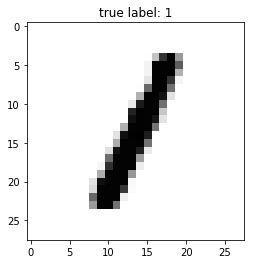

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_digit(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y[idx])
    plt.show()
plot_digit(X, y, 600)

In [7]:
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/d5/1c/3ac472009a5c54ae7ec5a3294520ca36d1908cd1e5cf3e3fd923f9b7b31f/tensorflow-1.13.1-cp37-cp37m-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c0/bf/0315ef6a9fd3fc2346e85b0ff1f5f83ca17073f2c31ac719ab2e4da0d4a3/Keras_Preprocessing-1.0.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/39/bdd75b08a6fba41f098b6cb091b9e8c7a80e1b4d679a581a0ccd17b10373/tensorboard-1.13.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/48/13f49fc3fa0fdf916aa1419013bb8f2ad09674c275b4046d5ee669a46873/tensorflow_estimator-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/33/c0561fe7c5e235325255f46c08bd3d07f2c80824feb22d057328eff1f8b7/grpcio-1.19.0-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/90/85/64c82949765cfb246bbdaf5aca2d55f400f792655927a017710a78445def/Keras_Applications-1.0.7-py2.py3-no

In [8]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 3s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
60000/60000 [==============================] - 8s 128us/sample - loss: 0.2195 - acc: 0.9351
Epoch 2/5
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0964 - acc: 0.9708
Epoch 3/5
60000/60000 [==============================] - 7s 121us/sample - loss: 0.0684 - acc: 0.9786
Epoch 4/5
60000/60000 [==============================] - 7s 120us/sample - loss: 0.0527 - acc: 0.9830
Epoch 5/5
10000/10000 [==============================] - 0s 27us/sample - loss: 0.0773 - acc: 0.9770


[0.0773114256720466, 0.977]

In [9]:
from random import seed
from random import random
 
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network
 
seed(1)
network = initialize_network(2, 1, 2)
for layer in network:
    print(layer)

[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}]
[{'weights': [0.2550690257394217, 0.49543508709194095]}, {'weights': [0.4494910647887381, 0.651592972722763]}]


In [10]:
# Calculate neuron activation for an input
# the function assumes that the bias is the last weight 
# in the list of weights.

def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

In [11]:
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

In [12]:
# Forward propagate input to a network output
# You can see that a neuron’s output value is stored in the neuron
# with the name ‘output‘. You can also see that we collect the outputs 
# for a layer in an array named 'new_inputs' that becomes the array 'inputs'
# and is used as inputs for the following layer.

def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [13]:
from math import exp
 
# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation
 
# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))
 
# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs
 
# test forward propagation
network = [[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
        [{'weights': [0.2550690257394217, 0.49543508709194095]}, {'weights': [0.4494910647887381, 0.651592972722763]}]]
row = [1, 0, None]
output = forward_propagate(network, row)
print(output)

[0.6629970129852887, 0.7253160725279748]


In [14]:
# Calculate the derivative of a neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

In [15]:
# error signal calculated for each neuron is stored with the name ‘delta’
# ‘delta’ reflects the change the error 
# implies on the neuron (e.g. the weight delta)
# error signal for neurons in the hidden layer is accumulated 
# from neurons in the output layer where the hidden neuron number j is also
# the index of the neuron’s weight in the output layer neuron[‘weights’][j]


# Backpropagate error and store in neurons

def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [16]:
### put the back propagation together ###
# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])
 
# test backpropagation of error
network = [[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
        [{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095]}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763]}]]
expected = [0, 1]
backward_propagate_error(network, expected)
for layer in network:
    print(layer)

[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614], 'delta': -0.0005348048046610517}]
[{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095], 'delta': -0.14619064683582808}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763], 'delta': 0.0771723774346327}]


## Stretch Goals: 

- Implement Cross Validation model evaluation on your MNIST implementation 
- Research different [Gradient Descent Based Optimizers](https://keras.io/optimizers/)
 - [Siraj Raval the evolution of gradient descent](https://www.youtube.com/watch?v=nhqo0u1a6fw)
- Build a housing price estimation model using a neural network. How does its accuracy compare with the regression models that we fit earlier on in class?